In [1]:
import pandas as pd
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram

# Data import

## Iris

In [139]:
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

from sklearn.datasets import load_iris
iris_data = load_iris(return_X_y=False, as_frame=True)
iris_data.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


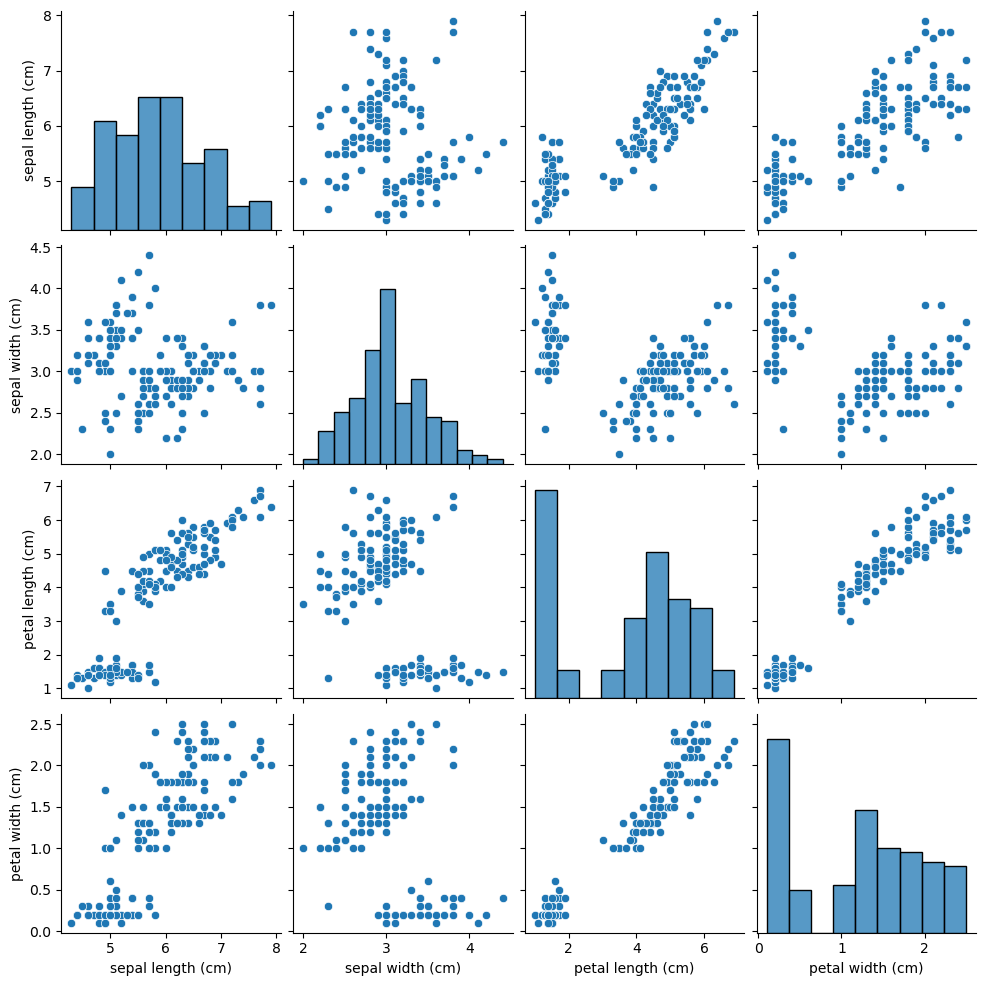

In [140]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
sns.pairplot(iris_data.data)
plt.show()

In [141]:
X = iris_data.data
target_labels = iris_data.target

## Small

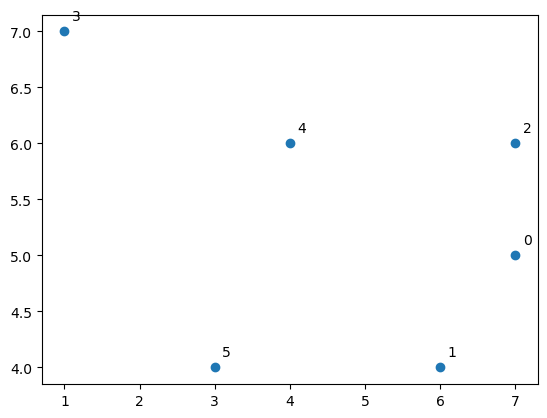

In [82]:
from matplotlib import pyplot as plt
import string

np.random.seed(42*5)

N = 6
X = np.random.randint(0, 10, (N, 2))
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1])

# for i, txt in enumerate(string.ascii_uppercase[:N]):
for i in range(N):
    txt = str(i)
    ax.annotate(txt, (X[i, 0], X[i, 1]), xytext=[X[i, 0]+0.1, X[i, 1]+0.1])

plt.show()

# Algorithms demo

## NNChain

### Code

In [131]:
class NNChainClustering():
    def __init__(self, n_clusters=2, metric='euclidean', linkage='average'):
        self.n_clusters = n_clusters

        metric_choices = {
            'euclidean': lambda a, b: np.sqrt(((a-b) ** 2).sum()),
            'precomputed': None
        }
        try:
            metric_func = metric_choices[metric]
        except KeyError as e:
            raise ValueError(
                f"Unknown metric."
            ) from e
        self._metric_func = metric_func

        def ward_join(p, q, D):
            N_p = np.count_nonzero(self.labels_ == p)
            N_q = np.count_nonzero(self.labels_ == q)
            D_t = np.ndarray((D.shape[0])) # distance row for new cluster
            # assert D[p][q] == np.min(D)

            non_masked = np.nonzero(~(D.mask[p] | D.mask[q]))
            for r in list(non_masked[0]):
                N_r = np.count_nonzero(self.labels_ == r)
                D_t[r] = np.sqrt(((N_r + N_p) * D[p][r] ** 2
                                  + (N_r + N_q) * D[q][r] ** 2
                                  - N_r * D[p][q] ** 2) / (N_p + N_q + N_r))
                pass

            return(D_t)

        linkage_choices = {
            'single': lambda i, j, D: np.minimum(D[i], D[j]),
            'average': lambda i, j, D: (D[i]+D[j])/2,
            'complete': lambda i, j, D: np.maximum(D[i], D[j]),
            'ward': ward_join
        }
        try:
            join_func = linkage_choices[linkage]
        except KeyError as e:
            raise ValueError(
                f"Unknown linkage. Should be one of {linkage_choices.keys()}"
            ) from e
        if linkage == 'ward' and metric not in ['euclidean', 'precomputed']:
            raise ValueError(
                f"Only euclidean disance is availible for ward's method."
            )
        self._join_func = join_func
        self._linkage = linkage

        self.distances_ = None
        self.children_ = None

    def __compute_distances(self, X):
        N = X.shape[0]
        matrix = np.empty((N, N))
        for i in range(N):
            for j in range(N):
                dist = self._metric_func(X[i], X[j])
                matrix[i, j] = dist
        self.distance_matrix = matrix

    def fit(self, X):
        if type(X) == pd.core.frame.DataFrame:
                    X = X.to_numpy()

        if self._metric_func != None:
            self.__compute_distances(X)
        else:
            self.distance_matrix = X

        D = self.distance_matrix
        N = D.shape[0]
        node_labels = list(range(N))

        # # mapping node labels to matrix indices
        # labels_to_idxs = np.empty(2*N-1, dtype=int)
        # # clusters of size 1 have indices 0,...,N-1
        # labels_to_idxs[:N] = np.arange(N, dtype=int) 

        idxs_to_labels = np.arange(N, dtype=int) 

        self.children_ = np.ndarray((N-1, 2), dtype='int')
        self.distances_ = np.ndarray((N-1))
        self.labels_ = np.arange(N)

        mask = np.zeros_like(D)
        D_masked = ma.masked_array(D, mask)
        D_masked.fill_value = np.inf
        np.fill_diagonal(D_masked.mask, 1)

        new_node_label = N
        chain = []
        # cluster_sizes = np.ones(2*N - 1) # N existing clusters and (N - 1) new (merged)
        while len(node_labels) > 1:
            # if len(chain) >= 3:
            #     a = chain[-3]
            #     b = chain[-2]
            #     for _ in range(3):
            #         chain.pop()

            # a = node_labels[0]
            # chain.append(a)
            # b = node_labels[1]
                
            if len(chain) <= 3:
                a = node_labels[0]
                chain.append(a)
                b = node_labels[1]
            else:
                a = chain[-4]
                b = chain[-3]
                for _ in range(3):
                    chain.pop()
                # chain = chain[:-3] 

            pass

            while True: # repeat until
                min_idxs = np.nonzero(D_masked[a] == D_masked[a].min())
                # c = b if labels_to_idxs[b] in min_idxs[0] else min_idxs[0][0] # prefer b
                c = b if b in min_idxs[0] else min_idxs[0][0] # prefer b
                a, b = c, a
                chain.append(c)    
                # if len(chain) >= 3 and a == chain[-3]: break
                if len(chain) > 3 and a == chain[-3]: break

            node_labels.remove(b)            
            node_labels.remove(a)

            # cluster_sizes[n] = cluster_sizes[a] + cluster_sizes[b]

            # calc distances
            new_cluster = np.atleast_2d(self._join_func(a, b, D_masked))
            # a_ind = labels_to_idxs[a]
            # b_ind = labels_to_idxs[b]
            # D_masked[:, [b_ind]] = ma.masked
            # D_masked[[b_ind], :] = ma.masked
            # D_masked.data[:, [a_ind]] = new_cluster.T
            # D_masked.data[[a_ind], :] = new_cluster

            # write to output
            # TODO: make sure every row from 0,..., N-1 exists
            # self.children_[new_node_label - N, :] = [a, b]
            self.children_[new_node_label - N, :] = idxs_to_labels[[b, a]]
            self.distances_[new_node_label - N] = D_masked[a, b]

            D_masked[:, [a]] = ma.masked
            D_masked[[a], :] = ma.masked
            D_masked.data[:, [b]] = new_cluster.T
            D_masked.data[[b], :] = new_cluster


            # # map new node label to existing matrix index
            # labels_to_idxs[new_node_label] = a

            idxs_to_labels[b] = new_node_label

            # node_labels.append(new_node_label)
            node_labels.append(b)
            new_node_label += 1
            
        # sort the unsorted dendrogram
        sorted_idx = self.distances_.argsort()
        self.children_ = self.children_[sorted_idx]
        self.distances_ = self.distances_[sorted_idx]

        return self

In [132]:
import pandas as pd

D = np.empty((N, N))
for i in range(N):
    for j in range(N):
        D[i, j] = D[j, i] = np.linalg.norm(X[i]-X[j])
display(pd.DataFrame(D))

model = NNChainClustering(linkage='ward')
model.fit(X)

,0,1,2,3,4,5
0,0.00,1.41,1.00,6.32,3.16,4.12
1,1.41,0.00,2.24,5.83,2.83,3.00
2,1.00,2.24,0.00,6.08,3.00,4.47
3,6.32,5.83,6.08,0.00,3.16,3.61
4,3.16,2.83,3.00,3.16,0.00,2.24
5,4.12,3.00,4.47,3.61,2.24,0.00


### Demo

In [142]:
%%time
# from hierarchical_clustering import NNChainClustering
linkage_types = ['ward', 'complete', 'average', 'single']
hclust_nnc = dict()
for linkage_type in linkage_types:
    model_nnc = NNChainClustering(linkage=linkage_type)
    clustering = model_nnc.fit(X)
    hclust_nnc[linkage_type] = clustering

CPU times: total: 2.97 s
Wall time: 2.97 s


In [149]:
linkage_dbg = 'average'
model = hclust_nnc[linkage_dbg]
print(model.distances_)

[0.   0.1  0.1  0.1  0.1  0.1  0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14
 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.16 0.16 0.17 0.17 0.17 0.17 0.17
 0.19 0.19 0.19 0.2  0.2  0.2  0.2  0.22 0.22 0.22 0.22 0.22 0.22 0.24
 0.24 0.24 0.24 0.24 0.24 0.24 0.25 0.26 0.26 0.26 0.26 0.26 0.26 0.26
 0.26 0.26 0.26 0.26 0.27 0.28 0.3  0.31 0.31 0.31 0.31 0.32 0.32 0.32
 0.32 0.32 0.33 0.33 0.33 0.33 0.33 0.34 0.35 0.35 0.35 0.37 0.37 0.37
 0.38 0.38 0.39 0.39 0.39 0.39 0.41 0.41 0.41 0.42 0.42 0.43 0.43 0.44
 0.44 0.45 0.45 0.45 0.47 0.48 0.5  0.5  0.5  0.5  0.5  0.5  0.52 0.53
 0.55 0.55 0.57 0.57 0.57 0.58 0.58 0.6  0.61 0.61 0.62 0.62 0.63 0.63
 0.66 0.66 0.68 0.72 0.74 0.75 0.84 0.86 0.89 0.9  0.9  0.97 0.98 1.05
 1.08 1.12 1.19 1.28 1.47 1.47 1.48 2.63 4.5 ]


In [138]:
print(hclust_naive[linkage_dbg].distances_)
hclust_naive[linkage_dbg].children_

[1.   1.83 2.24 3.3  4.7 ]


array([[0, 2],
       [6, 1],
       [4, 5],
       [7, 8],
       [9, 3]])

In [137]:
print(hclust_sklearn[linkage_dbg].distances_)
hclust_sklearn[linkage_dbg].children_

[1.   1.83 2.24 3.38 4.31]


array([[0, 2],
       [1, 6],
       [4, 5],
       [3, 8],
       [7, 9]])

In [151]:
for linkage_type in linkage_types:
    values, counts = np.unique(hclust_nnc[linkage_type].children_.flatten(), return_counts=True)
    repetitive_labels = values[counts > 1]
    isclose_dist = np.allclose(hclust_sklearn[linkage_type].distances_,
                hclust_nnc[linkage_type].distances_)
    isclose_child = np.allclose(hclust_sklearn[linkage_type].children_,
                hclust_nnc[linkage_type].children_)
    print(linkage_type, isclose_dist, isclose_child, repetitive_labels)

ward False False []
complete True False []
average False False []
single True False []


In [152]:
from scipy.cluster.hierarchy import fcluster

def get_linkage_matrix(model):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

def get_node_labels(linkage_matrix, n_clusters=None, threshold=None):
    assert n_clusters is not None or threshold is not None, \
        "either n_clusters or threshold should be supplied"

    if n_clusters is not None: 
        node_labels = fcluster(linkage_matrix, linkage_matrix[-n_clusters, 2])
    else:
        node_labels = fcluster(linkage_matrix, threshold, criterion='distance')

    # last_n_merges = linkage_matrix[linkage_matrix[:, 2] > linkage_colors[linkage_type]]
    # n_clusters = last_n_merges.shape[0] + 1
    # print(last_n_merges)
    # print(node_labels)

    return node_labels

def plot_dendrogram(model, color_threshold=None, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = get_linkage_matrix(model)
    node_labels = get_node_labels(linkage_matrix, threshold=color_threshold)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, color_threshold=color_threshold, **kwargs)
    return linkage_matrix, node_labels

In [154]:
# TODO: fix cluster counting

cutoff_thresholds = [4.5, 2, 1, 0.55]
linkage_colors = dict(zip(linkage_types, cutoff_thresholds))
labels = ['Уорда', 'Полной связи', "Средней связи", "Одиночной связи"]
linkage_labels = dict(zip(linkage_types, labels))

def visualize(hclust): 
    mpl.rcParams.update(mpl.rcParamsDefault)
    fig, axs = plt.subplots(2, 2)
    axs_indices = [(i, j) for i in range(2) for j in range(2)]
    for linkage_type, axs_ind in zip(linkage_types, axs_indices):
        linkage_matrix, node_labels = plot_dendrogram(
            model=hclust[linkage_type],
            truncate_mode="level",
            p=4,
            ax=axs[axs_ind],
            labels=None,
            color_threshold = linkage_colors[linkage_type]
            )

        n_clusters = len(np.unique(node_labels))
        title = f"Метод: {linkage_labels[linkage_type]} | Кластеров: {n_clusters}"
        axs[axs_ind].set_title(title, fontsize=20)
        axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')

    # fig.tight_layout()
    fig.set_size_inches(25, 10.5)
    fig.set_dpi(400)
    plt.show()

visualize(hclust_nnc)

ValueError: Linkage 'Z' uses non-singleton cluster before it is formed.

## Naive clustering

In [114]:
from hierarchical_clustering import AgglomerativeClustering

In [155]:
%%time
linkage_types = ['ward', 'complete', 'average', 'single']
hclust_naive = dict()
for linkage_type in linkage_types:
    model_naive = AgglomerativeClustering(linkage=linkage_type)
    clustering = model_naive.fit(X)
    hclust_naive[linkage_type] = clustering

CPU times: total: 2.59 s
Wall time: 2.62 s


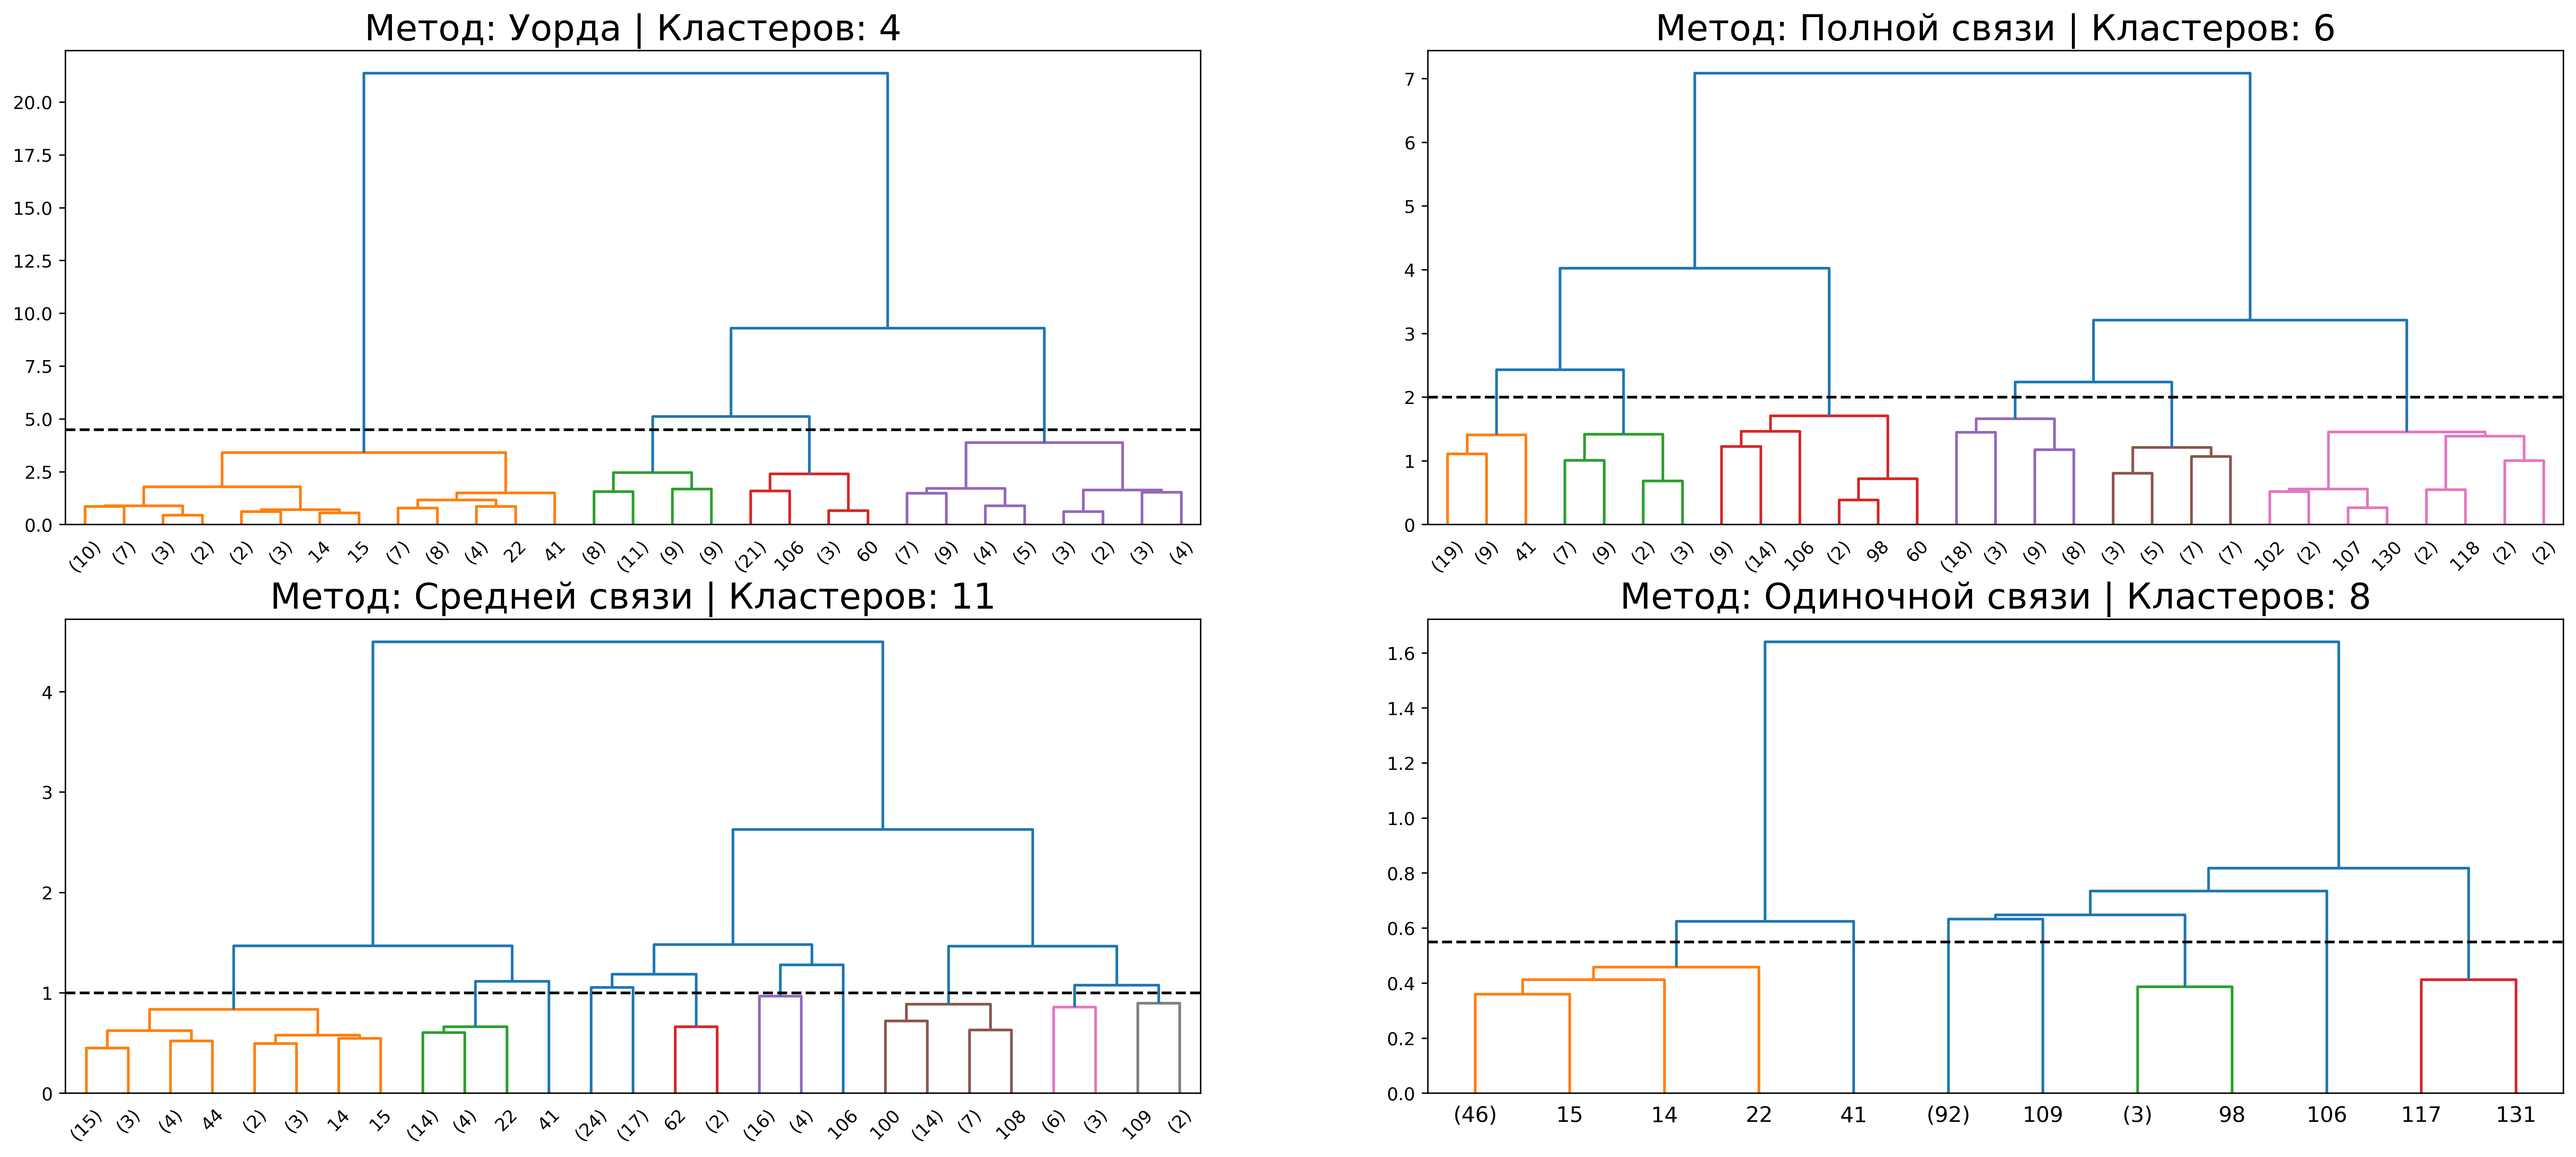

In [157]:
visualize(hclust_naive)

## Sklearn implementation

In [119]:
from sklearn.cluster import AgglomerativeClustering as AC_sklearn

In [158]:
%%time
linkage_types = ['ward', 'complete', 'average', 'single']
hclust_sklearn = dict()
for linkage_type in linkage_types:
    model_sklearn = AC_sklearn(linkage=linkage_type, n_clusters=None,
                                    distance_threshold=0,
                                    compute_distances=True)
    clustering = model_sklearn.fit(X)
    hclust_sklearn[linkage_type] = clustering

CPU times: total: 15.6 ms
Wall time: 22.1 ms


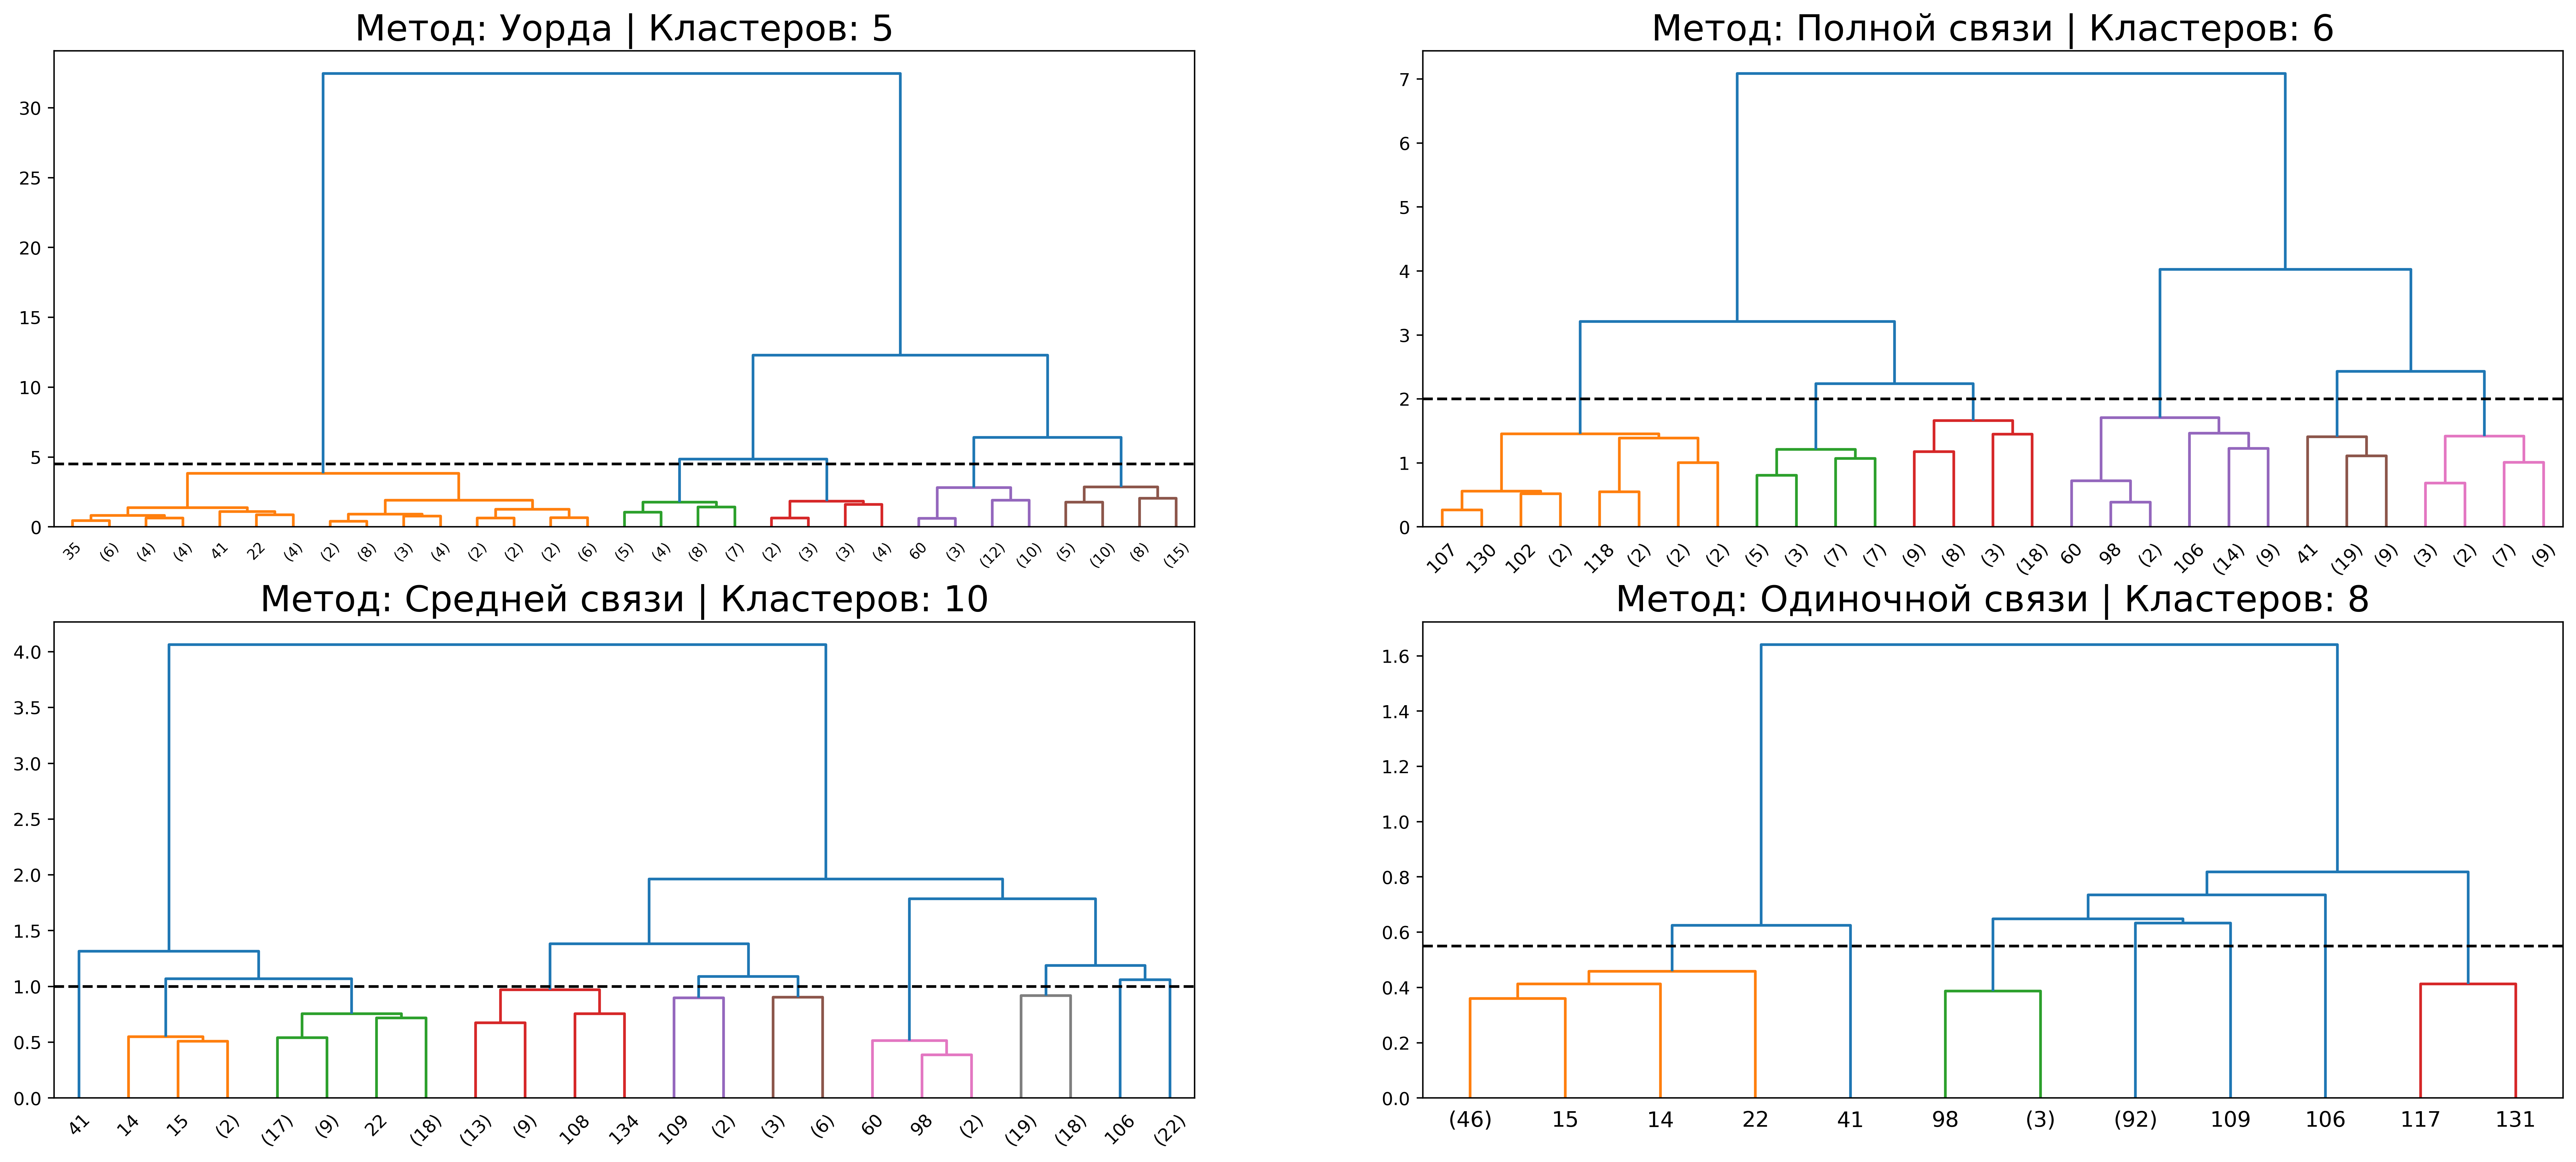

In [159]:
visualize(hclust_sklearn)